# Generating orientation dataset with halotools

In this notebook, we will be using the halo model-based intrinsic alignment model developed by Nick Van Alfen in Van Alfen et al. (in prep).



## Step I: Defining the halo model

In [3]:
# Uncomment to download the halo catalog
# from halotools.sim_manager import DownloadManager
# dman = DownloadManager()
# dman.download_processed_halo_table('bolshoi', 'rockstar', 0)

In [4]:
%pylab inline
import os 
os.environ['XLA_FLAGS']="--xla_gpu_force_compilation_parallelism=1"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

In [34]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace


sats_occ_model =  Zheng07Sats()
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.5, 15.2, 15))

# define the alignment models
from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment,\
    RadialSatelliteAlignment

central_orientation_model = CentralAlignment(central_alignment_strength=1.0)
satellite_orientation_model = RadialSatelliteAlignment(satellite_alignment_strength=0.75)

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

In [35]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

# For testing purposes, we are only going to keep halos with several satelittes
m = (model_instance.mock.galaxy_table['halo_num_satellites'] > 5) & (model_instance.mock.galaxy_table['halo_num_satellites'] < 70)
# Also removing halos close to the border to avoid border effects
m = m & (model_instance.mock.galaxy_table['halo_x'] > 10) & (model_instance.mock.galaxy_table['halo_x'] < 240)
m = m & (model_instance.mock.galaxy_table['halo_y'] > 10) & (model_instance.mock.galaxy_table['halo_y'] < 240)
m = m & (model_instance.mock.galaxy_table['halo_z'] > 10) & (model_instance.mock.galaxy_table['halo_z'] < 240)

galaxy_table = model_instance.mock.galaxy_table[m]

# Scaling mass 
galaxy_table['mass_scaled'] = log10(galaxy_table['halo_mvir_host_halo']) 
galaxy_table['mass_scaled'] = galaxy_table['mass_scaled'] - galaxy_table['mass_scaled'].mean()
galaxy_table['mass_scaled'] = galaxy_table['mass_scaled'] / galaxy_table['mass_scaled'].std()


# Centering all halos
galaxy_table['x'] = galaxy_table['x'] - galaxy_table['halo_x']
galaxy_table['y'] = galaxy_table['y'] - galaxy_table['halo_y']
galaxy_table['z'] = galaxy_table['z'] - galaxy_table['halo_z']

print("number of galaxies after filtering: ", len(galaxy_table))

number of galaxies:  74870
number of galaxies after filtering:  3391


/local/home/flanusse/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:190: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/local/home/flanusse/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:520: UserWarning: `satellite_alignment_strength` key not detected in `table`.The value set in self.param_dict of this class will be used instead.
  warn(msg)


## Step II: Create batches of graphs from this catalog

In [36]:
import jax
import jax.numpy as jnp
from functools import partial
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import egnn_jax
import optax

from deepghc.dataset import get_batch_fn

In [37]:
batch_fn = get_batch_fn(galaxy_table, 
                                vector_keys=['x', 'y', 'z', 
                                             'galaxy_axisA_x', 'galaxy_axisA_y', 'galaxy_axisA_z',
                                             'galaxy_axisB_x', 'galaxy_axisB_y', 'galaxy_axisB_z',
                                             'galaxy_axisC_x', 'galaxy_axisC_y', 'galaxy_axisC_z',],
                                scalar_keys=['mass_scaled'],
                                context_keys=['mass_scaled']
                               )

Precomputing dataset
Done


In [38]:
batch_init = batch_fn(jax.random.PRNGKey(0))
batch_init = jax.tree_map(lambda x:x[0], batch_init)

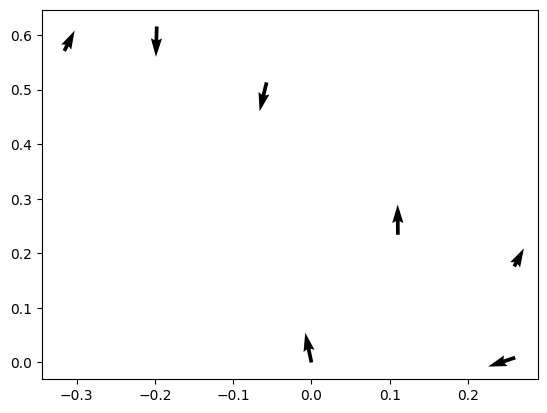

In [39]:
m = batch_init.nodes['vectors'][:,1,0] != 0
quiver(batch_init.nodes['pos'][:,0][m],
       batch_init.nodes['pos'][:,1][m],
       batch_init.nodes['vectors'][:,1,0][m],
       batch_init.nodes['vectors'][:,1,1][m])

In [176]:
# def EGCL(graph):
#     """ Equivariant Graph Layer expects nodes with x, and h
#     """
#     v = graph.nodes['v']
#     h = graph.nodes['h']
#     n_features = h.shape[-1]

#     d_ij = jnp.sum((v[graph.receivers] - v[graph.senders])**2, axis=-1)
    
#     m_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu)(
#             jnp.concatenate([h[graph.senders], 
#                              h[graph.receivers],
#                              d_ij, 
#                              graph.edges.reshape([-1,1])] ,axis=-1)
#             )
    
#     # Attention weight
#     e_ij = jax.nn.sigmoid(hk.Linear(1)(m_ij))

#     # Updating latents
#     new_h = jax.nn.leaky_relu(hk.Linear(n_features)(
#             jnp.concatenate([
#                 h, 
#                 jraph.segment_sum( (e_ij*m_ij)[graph.senders], graph.receivers, num_segments=70)
#             ], axis=-1)))
#     new_h = h + hk.Linear(n_features)(new_h)

#     # Updating vectors (but not the position)
#     d = (v[graph.senders] - v[graph.receivers])/(jnp.sqrt(jnp.expand_dims((d_ij), -1) + 0.1))
#     v_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu, name='vij')(
#             jnp.concatenate([h[graph.senders], 
#                              h[graph.receivers],
#                              d_ij, 
#                              graph.edges.reshape([-1,1])], axis=-1)
#             )
#     v_ij = hk.Linear(v.shape[-2], name='lin')(v_ij).reshape([-1, v.shape[-2], 1])
#     new_v = v + jraph.segment_sum((d * v_ij)[graph.senders], graph.receivers, num_segments=70)
    
#     return graph._replace(nodes={'v': new_v,
#                                  'h': new_h})

In [12]:
def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
    
    input_rotations = graph.nodes['vectors'][:,1:].reshape([-1,9])
    
    # Extract node positions 
    pos = graph.nodes['vectors'][...,0,:]
    
    graph = graph._replace(nodes=graph.nodes['scalars'])

    # Run the graph through an EGNN
    h, v = egnn_jax.EGNN(hidden_size=32, 
                               output_size=32,
                               normalize=False,
                               tanh=False, 
                              )(graph, pos)

    net = hk.nets.MLP([128, 128, 128], activation=jax.nn.leaky_relu)(jnp.concatenate([v, h, input_rotations], axis=-1))
    
    score = hk.Linear(3)(net)
    
    return graph._replace(nodes={'score': score})

In [13]:
network = hk.without_apply_rng(hk.transform(network_definition))
batch_init = batch_fn(jax.random.PRNGKey(42))
#Removing the batch dimension
batch_init = jax.tree_map(lambda x:x[0], batch_init)
params = network.init(jax.random.PRNGKey(42), batch_init)

In [14]:
from jaxlie import SO3
from so3dm.distributions import IsotropicGaussianSO3

/local/home/flanusse/.local/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/local/home/flanusse/.local/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/local/home/flanusse/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [15]:
@jax.vmap
def noise_fn1(u, key):
    x = SO3.from_matrix(u)
    dist = IsotropicGaussianSO3(x, 0.1)
    qn = dist.sample(seed=key)
    
    def fn(s,q):
        return dist.log_prob( (SO3(q) @ SO3.exp(s)).wxyz)
    
    score = jax.grad(fn)(jnp.zeros(3), qn)
    return {'vn': SO3(qn).as_matrix(), 'score': score}

@jax.jit
@jax.vmap
def noise_fn(u, key):
    return noise_fn1(u, jax.random.split(key, 70))

In [16]:
@jax.jit
@partial(jax.vmap, in_axes=[None, 0])
def prediction_loss(params, batch):
    decoded_nodes = network.apply(params, batch)
    
    loss = jnp.sum((decoded_nodes.nodes['score'] - batch.nodes['score'])**2, axis=-1)
    loss = decoded_nodes._replace(nodes=loss)
    
    # We create a mask to not consider the output of useless nodes
    loss = jraph.zero_out_padding(loss)
    
    n = jraph.get_number_of_padding_with_graphs_nodes(batch)
    
    return jnp.sum(loss.nodes)/n

@jax.jit
def update(params, opt_state, batch):
    l, g = jax.value_and_grad(lambda a,b:prediction_loss(a,b).mean())(params, batch)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state, l

In [17]:
opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(params)
seed = jax.random.PRNGKey(0)
losses = []

In [18]:
for step in range(100):
    seed, key, key2 = jax.random.split(seed, 3)
    # Draw a batch of graphs
    batch = batch_fn(key)
    # Add noise to graphs
    bn = noise_fn(batch.nodes['vectors'][:,:,1:], jax.random.split(key2, 32 ))
     
    batch = batch._replace(nodes={'scalars': batch.nodes['scalars'],
                                 'vectors': jnp.concatenate([
                                     batch.nodes['vectors'][:,:,0:1],
                                     bn['vn']],axis=-2),
                                 'true_vectors': batch.nodes['vectors'],
                                 'score': bn['score']})
    
    params, opt_state, l = update(params, opt_state, batch)
    losses.append(l)

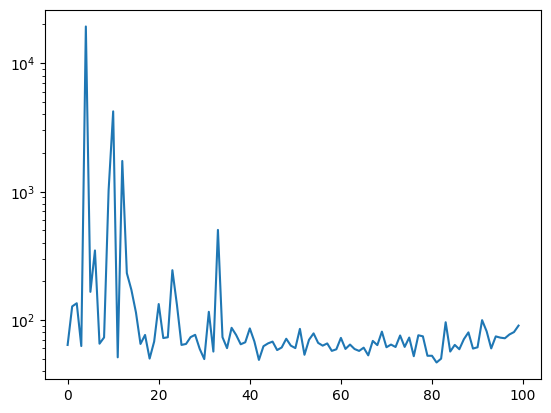

In [19]:
semilogy(losses[:])

In [21]:
res = jax.vmap(lambda x: network.apply(params, x))(batch)

In [188]:
# res.nodes['score'][0,0], batch.nodes['score'][0,0]

(Array([nan, nan, nan], dtype=float32),
 Array([-3.105552 ,  9.239253 , -0.9322221], dtype=float32))

In [22]:
# # with graph
# m = batch.nodes['true_vectors'][:,:,1,0] != 0
# hist(jnp.sum(res.nodes['score'][m]/jnp.sqrt(jnp.sum(res.nodes['score'][m]**2 ,axis=-1, keepdims=True) )* batch.nodes['true_vectors'][:,:,1][m], axis=-1));
# without graph
# m = batch.nodes['true_vectors'][:,:,1,0] != 0
# hist(jnp.sum(res.nodes['score'][m] * batch.nodes['true_vectors'][:,:,1][m], axis=-1));

In [23]:
# now, let's try to denoise 
@jax.vmap
@jax.vmap
def denoise(M, score):
    R = SO3.from_matrix(M)
    return (R @ SO3.exp(score*0.75**2)).as_matrix()

In [24]:
r = denoise(batch.nodes['vectors'][:,:,1:], batch.nodes['score'])
r2 = denoise(batch.nodes['vectors'][:,:,1:], res.nodes['score'])

(0.0, 5.0)

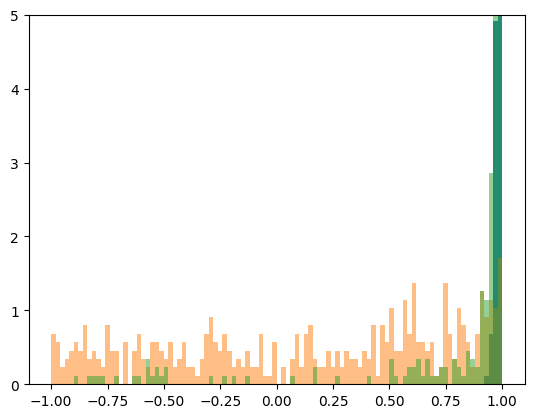

In [26]:
m = batch.nodes['true_vectors'][:,:,1,0] != 0
hist(jnp.sum(batch.nodes['vectors'][:,:,1][m] * batch.nodes['true_vectors'][:,:,1][m],axis=-1), 100, range=[-1,1],density=True, label='noisy');
hist(jnp.sum(r[:,:,0][m] * batch.nodes['true_vectors'][:,:,1][m],axis=-1), 100, range=[-1,1], density=True, alpha=0.5, label='true_denoise');
hist(jnp.sum(r2[:,:,0][m] * batch.nodes['true_vectors'][:,:,1][m],axis=-1), 100, range=[-1,1], density=True, alpha=0.5, label);
ylim(0,5)

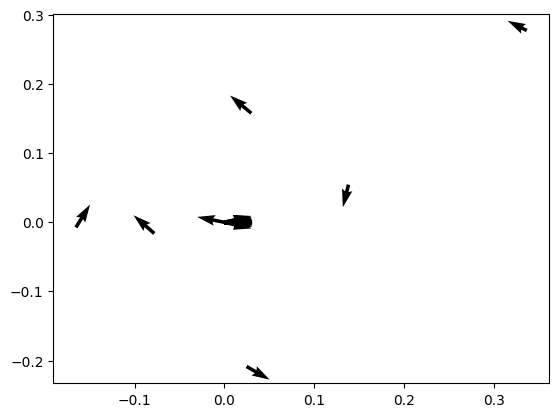

In [168]:
m = batch.nodes['vectors'][0,:,1,0]!=0
quiver(batch.nodes['vectors'][0,:,0,0][m], 
       batch.nodes['vectors'][0,:,0,1][m], 
       batch.nodes['vectors'][0,:,1,0][m], 
       batch.nodes['vectors'][0,:,1,1][m])

In [169]:
m = batch.nodes['pos'][0,:,0]>0
quiver(batch.nodes['pos'][0,:,0][m], 
       batch.nodes['pos'][0,:,1][m], 
       bn['vn'][0,:,0,0][m], 
       bn['vn'][0,:,0,1][m])

KeyError: 'pos'